In [1]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.data import wine_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import model_selection
import json
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
import random
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


In [ ]:
def class_fun(feature,profile,group):#
    exp_pre=profile.loc[feature,:]
    #test_exp_pre=test_profile.loc[feature,]
    dat2=exp_pre.stack()
    exp=dat2.unstack(0)
    #dat3=test_exp_pre.stack()
    #test_exp=dat3.unstack(0)
    rf_new = RandomForestClassifier()
    rf_new.fit(exp, group)
    #prediction = rf_new.predict(test_exp)
    #交叉验证，5次准确率
    scores = cross_val_score(rf_new, exp, group, cv=5,scoring='accuracy')
    #print(scores)
    accuracy_value=pd.DataFrame({'accuracy':scores})
    mean_acc=accuracy_value.loc[:,'accuracy'].mean()
    #print(mean_acc)
    #accuracy_selection.append(accuracy_score(prediction, test_group))
    #cvs_selection.append(np.mean(scores))
    ##train_roc
    y_score = rf_new.predict_proba(exp)[:,1]
    fpr,tpr,threshold = metrics.roc_curve(group, y_score)
    roc_auc = metrics.auc(fpr,tpr)
    ##test_roc
    #y_score = rf_new.predict_proba(test_exp)[:,1]
    #fpr,tpr,threshold = metrics.roc_curve(test_group, y_score)
    #roc_auc_test = metrics.auc(fpr,tpr)

    #print(pred_y_rf_new)
    importance=rf_new.feature_importances_
    data = { 'gene' : feature, 'importance' :importance }
    df = pd.DataFrame(data)
    df.loc['ROC']=['ROC',roc_auc]
    #df.loc['ROC_test']=['ROC_test',roc_auc_test]
    df.loc['Mean_accuracy']=['Mean_accuracy',mean_acc]

    return df

def combination_fun(x,profile,group):
    #gene_all=[]
    all_value=pd.DataFrame({'gene_pair':[],'gene':[],'importance':[],'Rank':[],'roc':[],'module_two_genes':[],
                            'iteration1':[],'iteration2':[]})
    module=x.iloc[:,1].drop_duplicates().values.tolist()
    for mm in module:
        print(mm)
        gene_module=x.loc[x['modeuleType'] != mm].gene.tolist()
        #print(gene_module)
        y=x[x.modeuleType.isin([mm])].gene
        for i in range(0,len(y)-1):
            for j in range(i+1,len(y)):
                gene=[y[i],y[j]]
                gene_all=gene_module+gene
                #print(gene_all)
                class_results=class_fun(gene_all,profile,group)#
                roc=class_results.loc['ROC'].importance
                #roc_test=class_results.loc['ROC_test'].importance
                mean_acc=class_results.loc['Mean_accuracy'].importance
                gene_importance=class_results.drop(index=["ROC","Mean_accuracy"])
                gene_importance['Rank'] = gene_importance['importance'].rank(method="average")

                #gene_all=gene_all.append(gene_importance)
                #roc_all.extend([roc])
                valuedf=pd.DataFrame({'gene_pair':'_'.join(gene),'gene':gene_importance.gene,'importance':gene_importance.importance,
                                      'Rank':gene_importance.Rank,
                                          'Mean_accuracy':mean_acc,
                                          'roc':roc,'module_two_genes':mm
                                          ,'iteration1':i,'iteration2':j})
                all_value=pd.concat([valuedf,all_value])
                #print(gene)
    gene_all=findgene_fun(all_value,x)
    all_value.to_csv('all_value_com_all_notest.csv')
#print(gene_all)
    return gene_all



def jurge_fun(x):
    if x[6]==x[9]:
        y="a"
    else:
        y="b"
    return y

def findgene_fun(df1,df2):
    module_res=pd.merge(df1,df2,on='gene')
    module_res.loc[:,'type'] = module_res.apply(jurge_fun,1)
    module_res.loc[:,'id'] = module_res.index
    module_res1 =module_res.loc[module_res['type']=='a']
    rank_accuracy=module_res1.groupby(['modeuleType']).apply(lambda t: t[(t['Mean_accuracy']==t['Mean_accuracy'].max())])
    rank_accuracy1=rank_accuracy.drop(columns=['modeuleType'])
    rank_accuracy1.reset_index(inplace=True)
    rank_impor=rank_accuracy1.groupby(['modeuleType']).apply(lambda t: t[(t['Rank']==t['Rank'].max())])
    rank_impor1=rank_impor.drop(columns=['modeuleType','level_1'])
    rank_impor1.reset_index(inplace=True)
    #res_last=pd.merge(module_res,rank_impor1,on='id',how='right')
    #print(res_last['gene_x'])
    res_last=rank_impor1.loc[:,['gene_pair','modeuleType']]
    return res_last.drop_duplicates()


#read data
#dat=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/h3n2_train.csv',header=0,index_col=0))
dat=pd.DataFrame(pd.read_csv('dm_inter_all.csv',header=0,index_col=0))
#dat=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/deg_expression_limma.csv',header=0,index_col=0))
#h3n2_group=pd.DataFrame(pd.read_csv('D:/wrok/flu_paper/data/result2/result_new/h3n2_group_all.csv',header=0,index_col=0))
gene=dat.index.tolist()
#dat1=dat.iloc[:,2:74]
dat2=dat.stack()

expression=dat2.unstack(0)
print(expression.shape)

####group
#group=[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]
group=[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]

print(len(group))


gene_module=pd.DataFrame(pd.read_csv('dm_inter_gene_module_all.csv'
                                      ,header=0,index_col=0))
print(gene_module.shape)
#last_iteration=circle_fun(500,gene_module,dat,group)#
arg_l = [(gene_module, dat, group) for i in range(1000)]

with Pool(48) as pool:
    res=pool.starmap(combination_fun, arg_l)
    pool.close()
    pool.join()

#def flat(a):
#    l=[]
#    for i in a:
#        if type(i) is list:
#            for j in i:
#                l.append(j)
#        else:
#            l.append(i)
#    return(l)
#gene_list = flat(res)
#print(gene_list)
#gene_count=Counter(gene_list)
#gene_count_all=pd.DataFrame.from_dict(gene_count,orient='index',columns=['count']).reset_index()

def flat(a):
    l=pd.DataFrame({'gene_pair':[],'modeuleType':[]})
    for i in a:
        l=pd.concat([l,i])
    return(l)

gene_list = flat(res)
print(gene_list)
type(gene_list)


tt=gene_list.groupby('modeuleType').value_counts()
#print(type(tt))
tt=tt.reset_index()
tt.columns = ['moduleType','gene_pair','count']
tt.to_csv('gene_count_all_notest.csv')


In [33]:
gene_count_all=pd.DataFrame(pd.read_csv('gene_count_all_notest.csv',header=0,index_col=0))
gene_count_all.head()

,moduleType,gene_pair,count
0,MEbrown,S100A12_ACOX1,96
1,MEbrown,ACOX1_CXCL1,96
2,MEbrown,ACOX1_DOCK5,96
3,MEbrown,S100A12_IL1R2,70
4,MEbrown,ACOX1_ALPL,48


In [34]:
gene_count_all.sort_values(by="count",ascending=False,inplace=True)

In [68]:
print(gene_count_all.groupby('moduleType').head(2))

   moduleType      gene_pair  count
0     MEbrown  S100A12_ACOX1     96
1     MEbrown    ACOX1_CXCL1     96
51      MEtan     CD79B_CD72     96
52      MEtan  CD79B_OSBPL10     96
26     MEcyan   PKN2_ANKRD11     96
27     MEcyan    RBM47_UBE2W     71


In [69]:
gene_all=['CD72','S100A12','CXCL1','PIK3CB','ACOX1','PKN2','ANKRD11','CD79B','OSBPL10']#gene_count_all.sort_values(by="count",ascending=False),'LIMS1','CORO2B','LIMS1','PKN2','ANKRD11'

In [80]:

test=class_fun(gene_all,dat,group)

print(test.loc['Mean_accuracy',].loc['importance',])

0.8305555555555555
0.8305555555555555


In [71]:
feature=gene_all
profile=dat
group=group
#test_profile=dat1
#test_group=y_test

In [77]:
exp_pre=profile.loc[feature,:]
    #test_exp_pre=test_profile.loc[feature,]
dat2=exp_pre.stack()
exp=dat2.unstack(0)
    #dat3=test_exp_pre.stack()
    #test_exp=dat3.unstack(0)
rf_new = RandomForestClassifier(random_state=2345)#random_state=2022
rf_new.fit(exp, group)
    


RandomForestClassifier(random_state=2345)

In [78]:
#prediction = rf_new.predict(test_exp)
    #交叉验证，5次准确率
scores = cross_val_score(rf_new, exp, group, cv=5,scoring='accuracy')
    #print(scores)
accuracy_value=pd.DataFrame({'accuracy':scores})
mean_acc=accuracy_value.loc[:,'accuracy'].mean()
print(mean_acc)
    #accuracy_selection.append(accuracy_score(prediction, test_group))
    #cvs_selection.append(np.mean(scores))
    ##train_roc
y_score = rf_new.predict_proba(exp)[:,1]
fpr,tpr,threshold = metrics.roc_curve(group, y_score)
roc_auc = metrics.auc(fpr,tpr)
    ##test_roc
    #y_score = rf_new.predict_proba(test_exp)[:,1]
    #fpr,tpr,threshold = metrics.roc_curve(test_group, y_score)
    #roc_auc_test = metrics.auc(fpr,tpr)
    
    #print(pred_y_rf_new)
importance=rf_new.feature_importances_
data = { 'gene' : feature, 'importance' :importance }
df = pd.DataFrame(data)
df.loc['ROC']=['ROC',roc_auc]
    #df.loc['ROC_test']=['ROC_test',roc_auc_test]
df.loc['Mean_accuracy']=['Mean_accuracy',mean_acc]
        
print(df)

0.8555555555555555
                        gene  importance
0                       CD72    0.124606
1                    S100A12    0.087410
2                      CXCL1    0.076216
3                     PIK3CB    0.050255
4                      ACOX1    0.238855
5                       PKN2    0.199782
6                    ANKRD11    0.047830
7                      CD79B    0.131851
8                    OSBPL10    0.043196
ROC                      ROC    1.000000
Mean_accuracy  Mean_accuracy    0.855556


In [83]:
scoring = {'accuracy': make_scorer(accuracy_score),
               'roc_auc': make_scorer(roc_auc_score),
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score)}
rf_cv_score = model_selection.cross_validate(rf_new, exp, group, cv=5, scoring=scoring)
print(rf_cv_score)

{'fit_time': array([0.1146481 , 0.10103011, 0.08835506, 0.08913326, 0.08171749]), 'score_time': array([0.01834178, 0.01034737, 0.0116539 , 0.01020598, 0.00950885]), 'test_accuracy': array([0.77777778, 0.875     , 0.875     , 0.875     , 0.875     ]), 'test_roc_auc': array([0.775, 0.9  , 0.875, 0.875, 0.875]), 'test_precision': array([0.8, 1. , 0.8, 0.8, 1. ]), 'test_recall': array([0.8 , 0.8 , 1.  , 1.  , 0.75]), 'test_f1_score': array([0.8       , 0.88888889, 0.88888889, 0.88888889, 0.85714286])}


In [84]:
acc=(0.77777778+ 0.875+ 0.875+0.875+0.875 )/5 
print(acc)
auc=(0.775+0.9+ 0.875+ 0.875+ 0.875 )/5
print(auc)
preci=(0.8+ 1.+ 0.8+ 0.8+ 1. )/5
print(preci)
recall=(0.8 + 0.8 + 1. + 1. + 0.75    )/5
print(recall)
f1=(0.8 + 0.88888889+ 0.88888889+ 0.88888889+ 0.85714286)/5
print(f1)

0.855555556
0.86
0.8800000000000001
0.8699999999999999
0.864761906


In [90]:
y_score

array([0.78, 0.99, 0.88, 0.76, 0.95, 1.  , 0.99, 0.8 , 0.28, 0.09, 0.04,
       0.25, 0.1 , 0.21, 0.19, 0.11, 0.6 , 0.98, 0.86, 0.91, 0.98, 0.98,
       0.98, 0.92, 0.89, 0.26, 0.08, 0.07, 0.11, 0.24, 0.04, 0.16, 0.16,
       0.84, 0.93, 0.74, 0.94, 0.96, 0.01, 0.05, 0.17])

No handles with labels found to put in legend.


Feature ranking:
1. feature OSBPL10 (0.043196)
2. feature ANKRD11 (0.047830)
3. feature PIK3CB (0.050255)
4. feature CXCL1 (0.076216)
5. feature S100A12 (0.087410)
6. feature CD72 (0.124606)
7. feature CD79B (0.131851)
8. feature PKN2 (0.199782)
9. feature ACOX1 (0.238855)


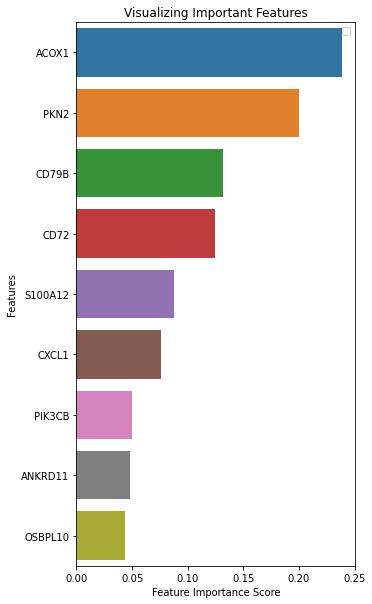

In [86]:
#print(pred_y_rf_new)
importance=rf_new.feature_importances_
#print(importance)
#print(gene)
indices = np.argsort(importance)
#print(indices)

# 输出排序
print("Feature ranking:")
featurerank=[]
im_value=[]
for f in range(exp.shape[1]):
    featurerank.append(gene_all[indices[f]])
    im_value.append(importance[indices[f]])
    print("%d. feature %s (%f)" % (f + 1, gene_all[indices[f]], importance[indices[f]]))
#特征重要性可视化
plt.figure(figsize=(5,10))
feature_imp = pd.Series(im_value,index=featurerank).sort_values(ascending=False)
sns.barplot(x= feature_imp,y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [87]:
data = { 'gene' : featurerank, 'importance' :im_value }
df = pd.DataFrame(data)
df.tail()
#df.iloc[305::]['gene']
df.to_csv('deg_module__inter_importance_all.csv')
df[df['importance']>0]

,gene,importance
0,OSBPL10,0.043196
1,ANKRD11,0.047830
2,PIK3CB,0.050255
3,CXCL1,0.076216
4,S100A12,0.087410
5,CD72,0.124606
6,CD79B,0.131851
7,PKN2,0.199782
8,ACOX1,0.238855


In [89]:
print(y_score)
#print(y_test)
print(tpr)
print(fpr)
print(roc_auc)


[0.78 0.99 0.88 0.76 0.95 1.   0.99 0.8  0.28 0.09 0.04 0.25 0.1  0.21
 0.19 0.11 0.6  0.98 0.86 0.91 0.98 0.98 0.98 0.92 0.89 0.26 0.08 0.07
 0.11 0.24 0.04 0.16 0.16 0.84 0.93 0.74 0.94 0.96 0.01 0.05 0.17]
[0.         0.04545455 0.13636364 0.31818182 1.         1.
 1.         1.         1.         1.        ]
[0.         0.         0.         0.         0.         0.36842105
 0.57894737 0.84210526 0.94736842 1.        ]
1.0
